Initialisation stage

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from datetime import timedelta, date

import project_01

We read a weekly file from the MTA website to determine its structure

In [4]:
dateparse = lambda dates: [time.strptime(d, '%m/%d/%Y') for d in dates]

mta_test = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190202.txt", parse_dates=['DATE'])

##mta_test = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190202.txt")

In [5]:
mta_test.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,03:00:00,REGULAR,6922652,2347673
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,07:00:00,REGULAR,6922669,2347688
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,11:00:00,REGULAR,6922747,2347773
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,15:00:00,RECOVR AUD,6922932,2347849
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,19:00:00,REGULAR,6923237,2347911


The 'ENTRIES' column name is dirty!

In [6]:
mta_test.columns.values

array(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE',
       'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype=object)

Rename the column

In [7]:
mta_test.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [8]:
mta_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202912 entries, 0 to 202911
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   C/A       202912 non-null  object        
 1   UNIT      202912 non-null  object        
 2   SCP       202912 non-null  object        
 3   STATION   202912 non-null  object        
 4   LINENAME  202912 non-null  object        
 5   DIVISION  202912 non-null  object        
 6   DATE      202912 non-null  datetime64[ns]
 7   TIME      202912 non-null  object        
 8   DESC      202912 non-null  object        
 9   ENTRIES   202912 non-null  int64         
 10  EXITS     202912 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 17.0+ MB


We found that the DESC column has a small amout of 'RECOVR AUD', which we learned refers to audits updated 

In [9]:
mta_test['DESC'].value_counts()

REGULAR       201952
RECOVR AUD       960
Name: DESC, dtype: int64

The names of stations are not in a consistant format

In [10]:
mta_test['STATION'].value_counts().head(20)

34 ST-PENN STA     4195
FULTON ST          4016
23 ST              3081
GRD CNTRL-42 ST    2955
CANAL ST           2476
86 ST              2467
34 ST-HERALD SQ    2295
CHAMBERS ST        2266
59 ST              2149
42 ST-PORT AUTH    2142
WALL ST            2135
TIMES SQ-42 ST     2134
ATL AV-BARCLAY     2032
125 ST             1810
PATH NEW WTC       1774
59 ST COLUMBUS     1722
14 ST              1690
28 ST              1654
14 ST-UNION SQ     1638
CORTLANDT ST       1625
Name: STATION, dtype: int64

In [11]:
mta_test['TIME'].value_counts()

03:00:00    17249
07:00:00    17243
19:00:00    17221
15:00:00    17217
23:00:00    17213
            ...  
02:09:23        1
10:23:08        1
17:49:51        1
22:31:21        1
20:33:30        1
Name: TIME, Length: 12614, dtype: int64

Grouping by Station, C/A, unit, SCP (and optionally date), and then taking the difference between max and min of entry and exit counters

In [12]:

(mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min())

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-01-28       0
                                 2019-01-29       0
                                 2019-01-30       0
                                 2019-01-31       0
                                 2019-02-01       0
Name: ENTRIES, Length: 33631, dtype: int64

In [13]:
mta_test['EXITS']

0         2347673
1         2347688
2         2347773
3         2347849
4         2347911
           ...   
202907        368
202908        368
202909        368
202910        368
202911        368
Name: EXITS, Length: 202912, dtype: int64

In [14]:
## gets the number of entries and exits
mta_entries = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min()

mta_exits = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.min()


This is what the grouped data looks like before flattening

In [15]:
print(mta_entries)
print(mta_exits)

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-01-28       0
                                 2019-01-29       0
                                 2019-01-30       0
                                 2019-01-31       0
                                 2019-02-01       0
Name: ENTRIES, Length: 33631, dtype: int64
STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    3718
                                 2019-01-27    3120
                                 2019-01-28    3597
                                 2019-01-29    3831
                                 2019-01-30    3534
                                     

Flatten and merge the entry and exit datasets

In [113]:
mta_entries_flat = mta_entries.reset_index()
mta_exits_flat = mta_exits.reset_index()

mta_entries_exits = pd.merge(mta_entries_flat, mta_exits_flat, how='outer')
print(mta_entries_exits)

STATION   C/A  UNIT       SCP       DATE  ENTRIES  EXITS
0           1 AV  H007  R248  00-00-00 2019-01-26     2753   3718
1           1 AV  H007  R248  00-00-00 2019-01-27     2070   3120
2           1 AV  H007  R248  00-00-00 2019-01-28     3842   3597
3           1 AV  H007  R248  00-00-00 2019-01-29     4201   3831
4           1 AV  H007  R248  00-00-00 2019-01-30     4274   3534
...          ...   ...   ...       ...        ...      ...    ...
33626  ZEREGA AV  R419  R326  00-05-01 2019-01-28        0      0
33627  ZEREGA AV  R419  R326  00-05-01 2019-01-29        0      0
33628  ZEREGA AV  R419  R326  00-05-01 2019-01-30        0      0
33629  ZEREGA AV  R419  R326  00-05-01 2019-01-31        0      0
33630  ZEREGA AV  R419  R326  00-05-01 2019-02-01        0      0

[33631 rows x 7 columns]


Append weekday and traffic column to dataset

In [121]:
mta_entries_exits['WEEKDAY'] = mta_entries_exits['DATE'].dt.day_name()
mta_entries_exits['TRAFFIC'] = mta_entries_exits['ENTRIES'] + mta_entries_exits['EXITS']

Remove rows with erronous jumps

In [123]:
mta_entries_exits = mta_entries_exits[mta_entries_exits.TRAFFIC < 50000]

Group by station and date (including weekday) and flatten the resultant dataset

In [124]:
mta_bystation = mta_entries_exits.groupby(['STATION','DATE','WEEKDAY']).sum().reset_index()

In [177]:
mta_bystation

,STATION,DATE,WEEKDAY,ENTRIES,EXITS,TRAFFIC
0,1 AV,2019-01-26,Saturday,15001,18465,33466
1,1 AV,2019-01-27,Sunday,11887,14116,26003
2,1 AV,2019-01-28,Monday,18617,21205,39822
3,1 AV,2019-01-29,Tuesday,19714,23064,42778
4,1 AV,2019-01-30,Wednesday,19708,22868,42576
...,...,...,...,...,...,...
2637,ZEREGA AV,2019-01-28,Monday,2637,2074,4711
2638,ZEREGA AV,2019-01-29,Tuesday,2754,2298,5052
2639,ZEREGA AV,2019-01-30,Wednesday,2715,2248,4963
2640,ZEREGA AV,2019-01-31,Thursday,2207,1836,4043


In [126]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"]

,STATION,DATE,WEEKDAY,ENTRIES,EXITS,TRAFFIC
427,34 ST-PENN STA,2019-01-26,Saturday,77849,75662,153511
428,34 ST-PENN STA,2019-01-27,Sunday,66531,63272,129803
429,34 ST-PENN STA,2019-01-28,Monday,161183,145887,307070
430,34 ST-PENN STA,2019-01-29,Tuesday,169162,155165,324327
431,34 ST-PENN STA,2019-01-30,Wednesday,165812,153787,319599
432,34 ST-PENN STA,2019-01-31,Thursday,157907,143326,301233
433,34 ST-PENN STA,2019-02-01,Friday,157598,148396,305994


In [24]:
weekday_dict = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

Which are the top 5 stations by entries and exits?

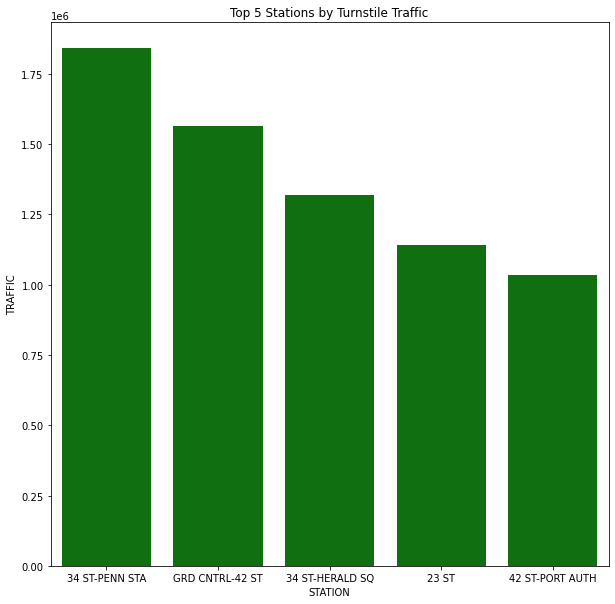

In [176]:
mta_top5 = mta_bystation.groupby('STATION').sum().reset_index().sort_values('TRAFFIC', ascending=False).head(5)

plt.figure(figsize=(10,10))
sns.barplot(data=mta_top5, x = 'STATION', y = 'TRAFFIC', color='green').set(title='Top 5 Stations by Turnstile Traffic');

plt.savefig('top5stations.svg')


In [48]:
mta_test.DATE.iloc[0]

Timestamp('2019-01-26 00:00:00')

In [112]:
mta_entries_exits.sort_values('TRAFFIC', ascending=False).head(30)

,STATION,C/A,UNIT,SCP,DATE,ENTRIES,EXITS,WEEKDAY,TRAFFIC
872,125 ST,R258,R132,00-03-03,2019-01-30,985981885,668438621,Wednesday,1654420506
28383,PARKCHESTER,R417,R222,00-00-04,2019-01-30,167155517,267410184,Wednesday,434565701
20964,FT HAMILTON PKY,N544,R289,01-05-01,2019-01-30,15728818,6160632,Wednesday,21889450
1133,137 ST CITY COL,R175,R169,01-00-00,2019-02-01,2807276,16576961,Friday,19384237
17013,CHAMBERS ST,R116,R030,00-00-00,2019-01-30,7083384,10006789,Wednesday,17090173
4628,28 ST,R228,R143,00-00-02,2019-01-29,5752829,5533765,Tuesday,11286594
25286,KNICKERBOCKER,K019,R413,00-00-00,2019-01-29,2526862,2476772,Tuesday,5003634
25285,KNICKERBOCKER,K019,R413,00-00-00,2019-01-28,2526178,2473678,Monday,4999856
25293,KNICKERBOCKER,K019,R413,00-00-01,2019-01-29,910614,1677255,Tuesday,2587869
25292,KNICKERBOCKER,K019,R413,00-00-01,2019-01-28,910297,1676239,Monday,2586536


In [54]:
mta_entries_flat[(mta_entries_flat.STATION == '125 ST') & (mta_entries_flat.DATE == pd.Timestamp('2019-01-30 00:00:00'))]

,STATION,C/A,UNIT,SCP,DATE,ENTRIES
669,125 ST,N025,R102,01-00-00,2019-01-30,1238
676,125 ST,N025,R102,01-00-01,2019-01-30,1114
683,125 ST,N025,R102,01-00-02,2019-01-30,1104
690,125 ST,N025,R102,01-00-03,2019-01-30,993
697,125 ST,N025,R102,01-00-04,2019-01-30,1859
704,125 ST,N025,R102,01-06-00,2019-01-30,700
711,125 ST,N026,R102,00-00-00,2019-01-30,3434
718,125 ST,N026,R102,00-00-01,2019-01-30,2941
725,125 ST,N026,R102,00-00-02,2019-01-30,2052
732,125 ST,N026,R102,00-00-03,2019-01-30,1364


There are big unexplained jumps in counter numbers at certain parts of the data (see last three rows below)

In [97]:
filter = (mta_test['STATION'] == '125 ST') & (mta_test['C/A'] == 'R258') & (mta_test['SCP'] == '00-03-03')
mta_test[filter].head(30) 

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
164231,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,00:00:00,REGULAR,3888393,2659898
164232,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,04:00:00,REGULAR,3888433,2659961
164233,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,08:00:00,REGULAR,3888523,2660074
164234,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,12:00:00,REGULAR,3888767,2660272
164235,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,16:00:00,REGULAR,3889047,2660460
164236,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,20:00:00,REGULAR,3889323,2660636
164237,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,00:00:00,REGULAR,3889445,2660788
164238,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,04:00:00,REGULAR,3889476,2660850
164239,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,08:00:00,REGULAR,3889520,2660934
164240,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,12:00:00,REGULAR,3889667,2661092


Plot the traffic for top 5 stations; weekends are highlighted 

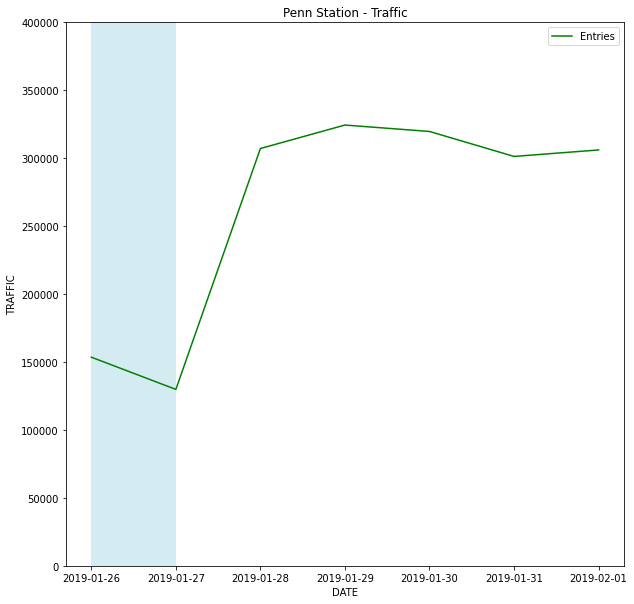

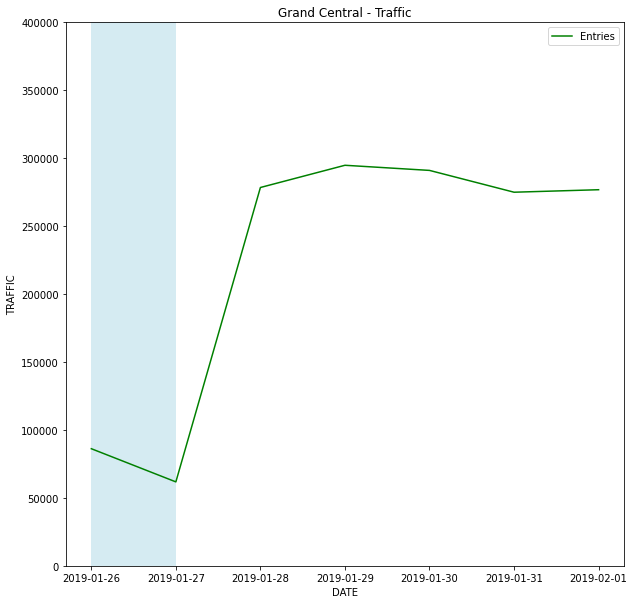

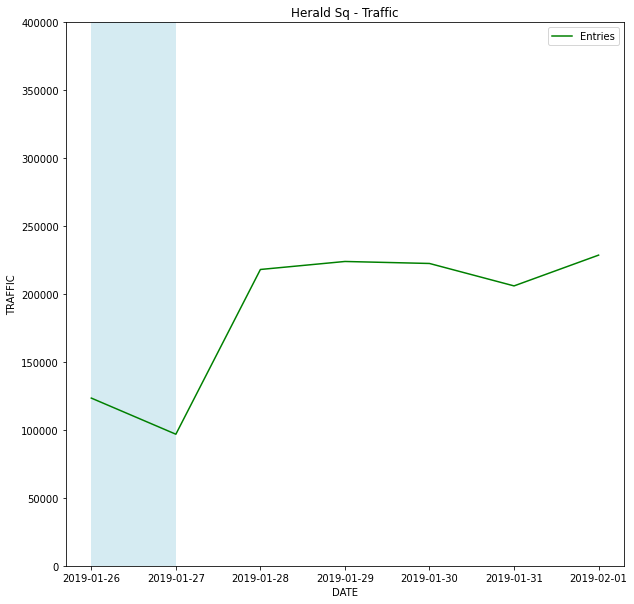

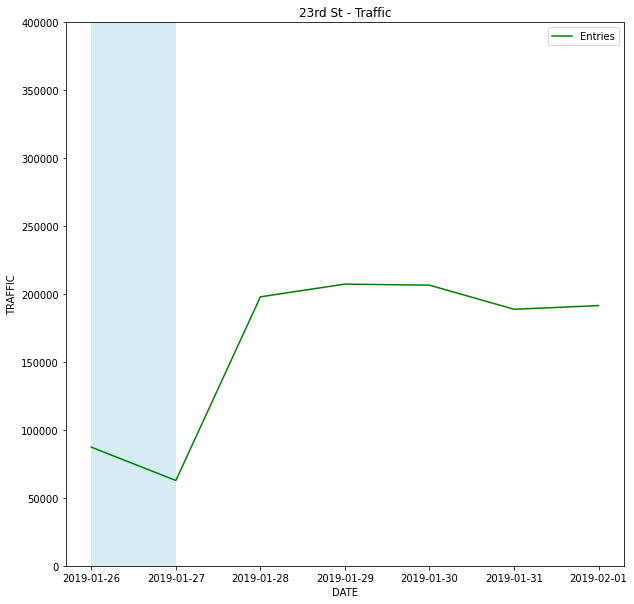

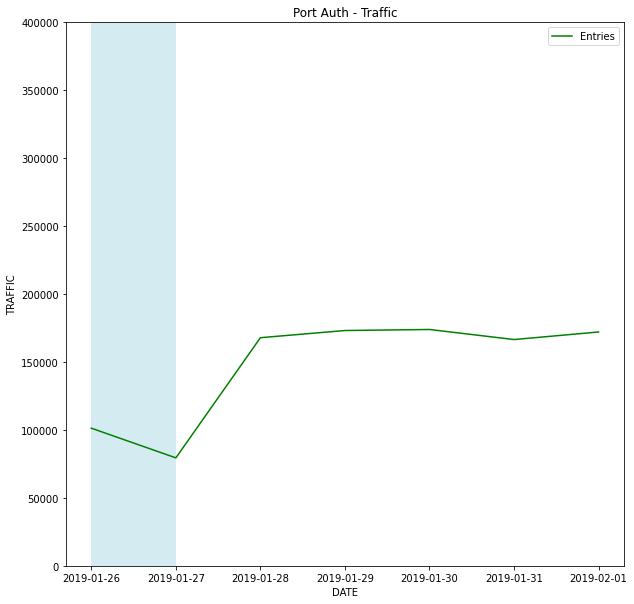

In [168]:
import project_01 as p1

mta = {}
plot_num = 0

mta['penn'] = [mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"], 'Penn Station']
mta['grdcntrl'] = [mta_bystation[mta_bystation.STATION == "GRD CNTRL-42 ST"], 'Grand Central']
mta['heraldsq'] = [mta_bystation[mta_bystation.STATION == "34 ST-HERALD SQ"], 'Herald Sq']
mta['23rd'] = [mta_bystation[mta_bystation.STATION == "23 ST"], '23rd St']
mta['portauth'] = [mta_bystation[mta_bystation.STATION == "42 ST-PORT AUTH"], 'Port Auth']
#mta['unionsq'] = [mta_bystation[mta_bystation.STATION == "14 ST-UNION SQ"], 'Union Sq']
#mta['timessq'] = [mta_bystation[mta_bystation.STATION == "TIMES SQ-42 ST"], 'Times Sq']

for station in mta:

    fig, axs = plt.subplots(nrows=1, figsize=(10,10))

    sns.lineplot(data = mta[station][0], x='DATE', y='TRAFFIC', color='green', ax=axs, label='Entries').set(ylim=(0,400000),title=mta[station][1] + ' - Traffic')
    weekend_indices = p1.find_weekend_indices(mta[station][0].DATE.tolist())
    p1.highlight_datetimes(weekend_indices, axs, mta[station][0])
    axs.legend();

    plt.savefig(station + '_week.svg')


In [183]:
mta_bystation.groupby(['STATION','DATE']).sum().reset_index()

,STATION,DATE,ENTRIES,EXITS,TRAFFIC
0,1 AV,2019-01-26,15001,18465,33466
1,1 AV,2019-01-27,11887,14116,26003
2,1 AV,2019-01-28,18617,21205,39822
3,1 AV,2019-01-29,19714,23064,42778
4,1 AV,2019-01-30,19708,22868,42576
...,...,...,...,...,...
2637,ZEREGA AV,2019-01-28,2637,2074,4711
2638,ZEREGA AV,2019-01-29,2754,2298,5052
2639,ZEREGA AV,2019-01-30,2715,2248,4963
2640,ZEREGA AV,2019-01-31,2207,1836,4043


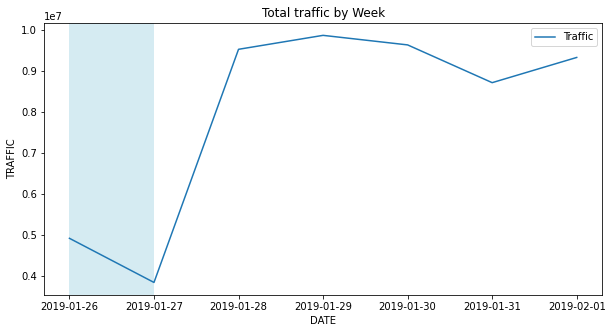

In [190]:
fig, axs = plt.subplots(nrows=1,figsize=(10,5))

sns.lineplot(data = mta_bystation.groupby('DATE').sum().reset_index(), x='DATE', y='TRAFFIC', ax=axs, label="Traffic").set(title='Total traffic by Week')

weekend_indices = p1.find_weekend_indices(mta['penn'][0].DATE.tolist())
p1.highlight_datetimes(weekend_indices, axs, mta['penn'][0])
plt.savefig('weekly_traffic_total.svg');

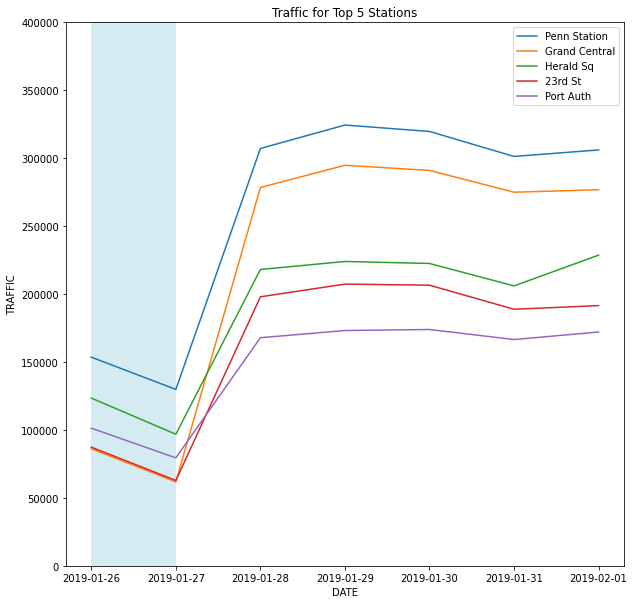

In [191]:
fig, axs = plt.subplots(nrows=1,figsize=(10,10))

for station in mta:
    sns.lineplot(data = mta[station][0], x='DATE', y='TRAFFIC', ax=axs, label=mta[station][1]).set(title='Traffic for Top 5 Stations', ylim=(0,400000))

weekend_indices = p1.find_weekend_indices(mta['penn'][0].DATE.tolist())
p1.highlight_datetimes(weekend_indices, axs, mta['penn'][0])
axs.legend();

plt.savefig('top5traffic.svg')

In [202]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].at[427, 'DATE']

Timestamp('2019-01-26 00:00:00')

In [205]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].index[0]

427

In [55]:
mta_stations = pd.read_excel("http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls")

In [56]:
mta_stations.head()

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT


### TODO:

- transit data from Feb 2 to Mar 29 2019
    - MVP: week ending Feb 2 2019
- header file for stations/booths (filtering by station)
    - MVP: top 5 stations
- focus on data between 8 am and 8 pm
    - MVP: focus on day (24 hour period)

### Immeadiate tasks:

- combine turnstile and station data
- plot data (day vs vol of passanger)


- combine data from different weeks
- filter/group data by station
- columns: stations, station exits, day of week, number of exits, number of entrances
- determine the difference between REGULAR and RECOVER AUD in DESC column ->> RECOVER AUD adds recovered data after the fact
- group traffic data by stations, see trends on weekdays vs weekends


In [45]:
mta_station_geoloc = pd.read_json("https://data.ny.gov/resource/i9wp-a4ja.json")

In [46]:
mta_station_geoloc.head()

,division,line,station_name,station_latitude,station_longitude,route1,entrance_type,entry,vending,staffing,...,route4,route5,route6,route7,route8,route9,ada_notes,staff_hours,route10,route11
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
mta_exits_geoloc = pd.read_csv("https://raw.githubusercontent.com/chriswhong/nycturnstiles/master/geocoded.csv", header=None, names=['Remote','Booth', 'Station Name', 'Station ID', 'Division', 'Latitute', 'Longitude'])

In [48]:
mta_exits_geoloc.head()

,Remote,Booth,Station Name,Station ID,Division,Latitute,Longitude
0,R470,X002,ELTINGVILLE PK,Z,SRT,40.544600,-74.164581
1,R544,PTH02,HARRISON,1,PTH,40.738879,-74.155533
2,R165,S102,TOMPKINSVILLE,1,SRT,40.636948,-74.074824
3,R070,S101,ST. GEORGE,1,SRT,40.643738,-74.073622
4,R070,S101A,ST. GEORGE,1,SRT,40.643738,-74.073622


In [91]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer:Union[str, pathlib.Path, IO[~AnyStr]],
    sep=',',
    delimiter=None,
    header='infer',
    names=None,
    index_col=None,
    usecols=None,
    squeeze=False,
    prefix=None,
    mangle_dupe_cols=True,
    dtype=None,
    engine=None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace=False,
    skiprows=None,
    skipfooter=0,
    nrows=None,
    na_values=None,
    keep_default_na=True,
    na_filter=True,
    verbose=False,
    skip_blank_lines=True,
    parse_dates=False,
    infer_datetime_format=False,
    keep_date_col=False,
    date_parser=None,
    dayfirst=False,
    cache_dates=True,
    iterator=False,
    chunksize=None,
    compression='infer',
    thousands=None,
    decimal:str='.',
    lineterminator=None,
    quotechar='"',
    quoting=0,
    doublequote=True,
    escapechar=None,
    comment=None,
    encoding=None,
    dialect=None,
    error_bad_lines=True,
    warn_bad_lines